# Classification with XGBoost

---

## 1. Load Data

The training, validation and test bottleneck features along with the associated targets are loaded.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from common import *

%matplotlib inline

bottleneck_features = np.load('data/bottleneck_features/yelp_resnet50_all.npz')

X_train = bottleneck_features['train_features']
X_valid = bottleneck_features['valid_features']
X_test  = bottleneck_features['test_features']

y_train = bottleneck_features['train_targets']
y_valid = bottleneck_features['valid_targets']
y_test  = bottleneck_features['test_targets']

Using TensorFlow backend.


## 2. Average Features
The above bottleneck features have been calculated for each photograph available. Multiple photographs can belong to the same business (see [eda.ipynb](eda.ipynb)). We derive a single feature vector per business by averaging the relevant bottleneck features for the training, validation and test datasets.

In [2]:
def biz_Xy(X, y, group):
    X_biz = []
    y_biz = []
    for g in group:
        X_biz.append(np.mean(X[g], axis=0))
        y_biz.append(y[g[0]])
    X_biz = np.array(X_biz)
    y_biz = np.array(y_biz)
    return X_biz, y_biz

# Training dataset
X_train = X_train.reshape(len(X_train),2048)
img_train, _ = load_dataset('data/preprocess/train.npz')
group_train = group_images(img_train, 'data/train_photo_to_biz_ids.csv')

X_train_averaged, y_train_averaged = biz_Xy(X_train, y_train, group_train)


# Validation dataset
X_valid = X_valid.reshape(len(X_valid),2048)
img_valid, _ = load_dataset('data/preprocess/valid.npz')
group_valid = group_images(img_valid, 'data/train_photo_to_biz_ids.csv')

X_valid_averaged, y_valid_averaged = biz_Xy(X_valid, y_valid, group_valid)


# Test dataset
X_test = X_test.reshape(len(X_test),2048)
img_test, _ = load_dataset('data/preprocess/test.npz')
group_test = group_images(img_test, 'data/train_photo_to_biz_ids.csv')

X_test_averaged, y_test_averaged = biz_Xy(X_test, y_test, group_test)

del X_train, X_valid, X_test, y_train, y_valid, y_test

Since the original training dataset has been divided in a training (75%), validation (12.5%) and test (12.5%) datasets, it is possible that some of the 2000 businesses are absent from the datasets.  

In [3]:
print("Shape of training dataset: (%d,%d)" % X_train_averaged.shape)
print("Shape of validation dataset: (%d,%d)" % X_valid_averaged.shape)
print("Shape of test dataset: (%d,%d)" % X_test_averaged.shape)

Shape of training dataset: (2000,2048)
Shape of validation dataset: (1946,2048)
Shape of test dataset: (1953,2048)


## 3. Features scaling

The features are standardized by removing the mean and scaling to unit variance. The scaler is first derived on the training data and then applied on the training, validation and test data. 

In [4]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train_averaged)
X_train_scaled = scaler.transform(X_train_averaged)
X_valid_scaled = scaler.transform(X_valid_averaged)
X_test_scaled  = scaler.transform(X_test_averaged)

## 4. Principal Component Analysis

A principal component analysis (PCA) is carried out in order reduce the number of bottleneck features. The plot below shows that the first 200 principal components capture about 85% of the variance in the training data. Not that this transformation allows to reduce the number of features from 2048 to 200, roughly one order of magnitude.

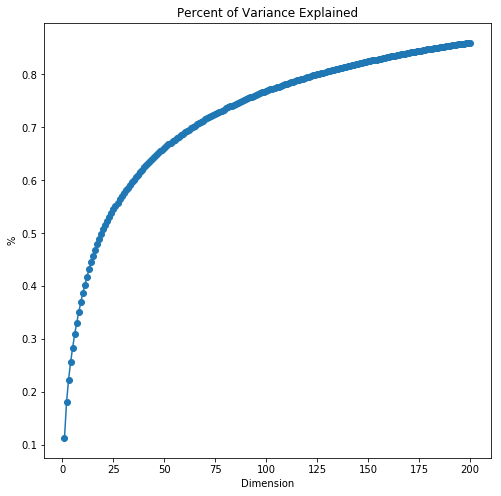

In [5]:
from sklearn.decomposition import PCA
n_comp = 200
pca = PCA(n_components=n_comp, svd_solver='randomized', whiten=True)
pca.fit(X_train_scaled)

X_train_reduced = pca.transform(X_train_scaled)
X_valid_reduced = pca.transform(X_valid_scaled)
X_test_reduced = pca.transform(X_test_scaled)

del X_train_scaled, X_valid_scaled, X_test_scaled

plt.figure(figsize=(8,8))
plt.plot(np.arange(1, n_comp+1), np.cumsum(pca.explained_variance_ratio_), '-o')
plt.xlabel('Dimension')
plt.ylabel('%')
plt.title("Percent of Variance Explained")
plt.show()

The scatter matrix of the first 10 principal components is shown below. As expected by construction, one can see that the principal components are uncorrelated.

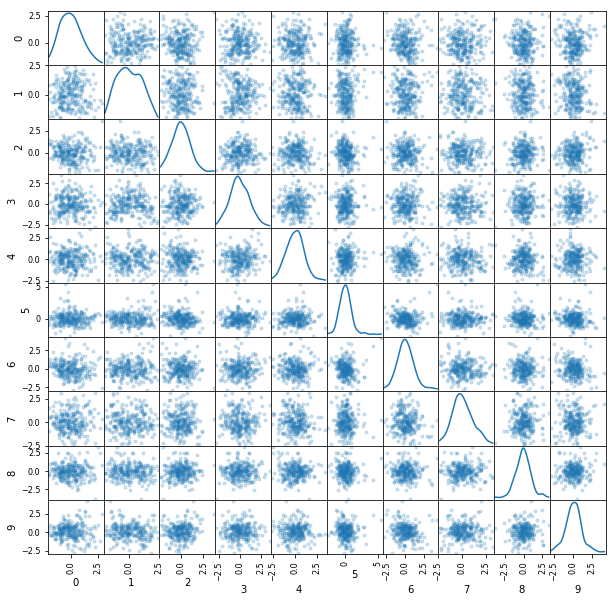

In [6]:
data = pd.DataFrame(X_train_reduced)

from pandas.tools.plotting import scatter_matrix
corr = scatter_matrix(data.iloc[:250,:10], alpha=0.2, figsize=(10, 10), diagonal='kde')

## 5. Classification with XGBoost

The XGBoost model is used for the classification. The logarithmic of the loss function is used as evaluation metric during the training.

### A. Independent case

We fit an independent XGBoost model for each class. The minimization is controlled by the validation data. If the value of the logarithmic loss function calculated on the validation does not improve over ten consecutive epochs then the training is stopped.

#### $\alpha$- Training

[0]	train-logloss:0.689567	valid-logloss:0.692582
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.423521	valid-logloss:0.603565
[200]	train-logloss:0.290467	valid-logloss:0.56378
[300]	train-logloss:0.209058	valid-logloss:0.530776
[400]	train-logloss:0.157852	valid-logloss:0.5083
[500]	train-logloss:0.124399	valid-logloss:0.49201
[600]	train-logloss:0.100787	valid-logloss:0.478824
[700]	train-logloss:0.083587	valid-logloss:0.469058
[800]	train-logloss:0.070808	valid-logloss:0.460876
[900]	train-logloss:0.06123	valid-logloss:0.455
[1000]	train-logloss:0.053654	valid-logloss:0.450753
[1100]	train-logloss:0.047581	valid-logloss:0.446203
[1200]	train-logloss:0.042617	valid-logloss:0.442436
[1300]	train-logloss:0.03849	valid-logloss:0.439316
Stopping. Best iteration:
[1374]	train-logloss:0.035944	valid-logloss:0.437328



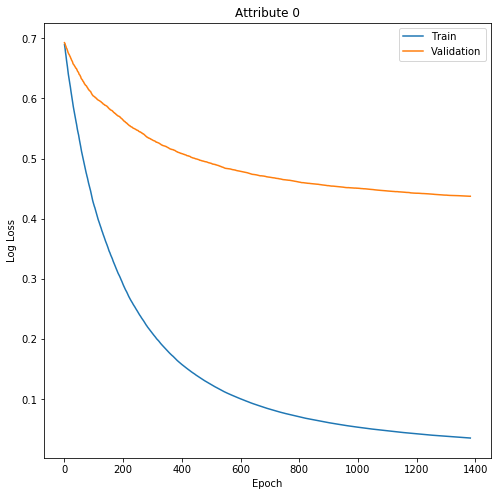

[0]	train-logloss:0.690904	valid-logloss:0.692759
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.424106	valid-logloss:0.609186
[200]	train-logloss:0.288907	valid-logloss:0.571057
[300]	train-logloss:0.205163	valid-logloss:0.538382
[400]	train-logloss:0.154105	valid-logloss:0.516199
[500]	train-logloss:0.120687	valid-logloss:0.501479
[600]	train-logloss:0.097189	valid-logloss:0.488906
[700]	train-logloss:0.080226	valid-logloss:0.4783
[800]	train-logloss:0.067635	valid-logloss:0.469846
[900]	train-logloss:0.058337	valid-logloss:0.464195
[1000]	train-logloss:0.050932	valid-logloss:0.458414
[1100]	train-logloss:0.045073	valid-logloss:0.453452
Stopping. Best iteration:
[1146]	train-logloss:0.042759	valid-logloss:0.451654



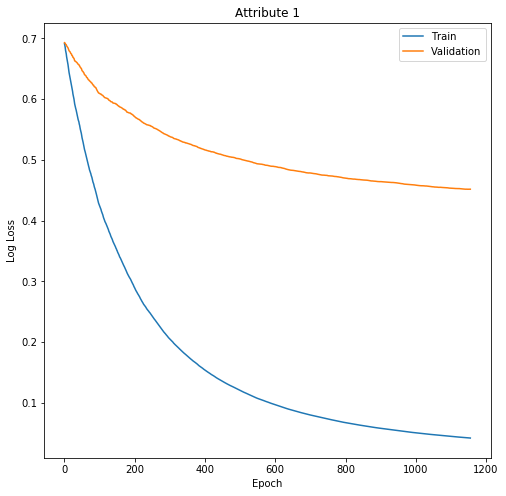

[0]	train-logloss:0.689966	valid-logloss:0.692498
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.409434	valid-logloss:0.586665
[200]	train-logloss:0.27366	valid-logloss:0.540455
[300]	train-logloss:0.190026	valid-logloss:0.502088
[400]	train-logloss:0.140447	valid-logloss:0.476476
[500]	train-logloss:0.109171	valid-logloss:0.460059
[600]	train-logloss:0.087122	valid-logloss:0.446192
[700]	train-logloss:0.071485	valid-logloss:0.434601
[800]	train-logloss:0.059906	valid-logloss:0.425433
[900]	train-logloss:0.051476	valid-logloss:0.419238
[1000]	train-logloss:0.045058	valid-logloss:0.415722
[1100]	train-logloss:0.039774	valid-logloss:0.411389
Stopping. Best iteration:
[1095]	train-logloss:0.040002	valid-logloss:0.411218



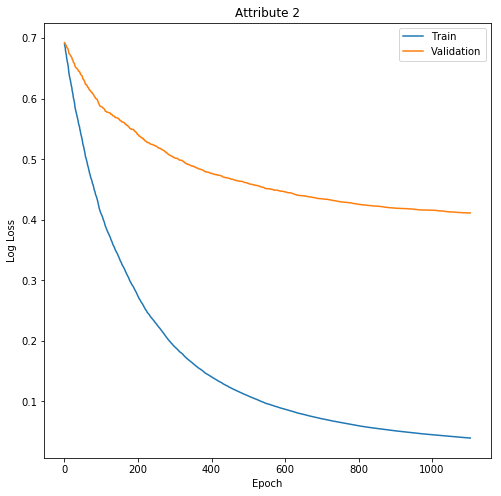

[0]	train-logloss:0.690321	valid-logloss:0.693043
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.471261	valid-logloss:0.665515
[200]	train-logloss:0.340443	valid-logloss:0.651425
[300]	train-logloss:0.25534	valid-logloss:0.641152
[400]	train-logloss:0.19824	valid-logloss:0.632437
[500]	train-logloss:0.158834	valid-logloss:0.625713
[600]	train-logloss:0.130279	valid-logloss:0.620584
Stopping. Best iteration:
[679]	train-logloss:0.113034	valid-logloss:0.615735



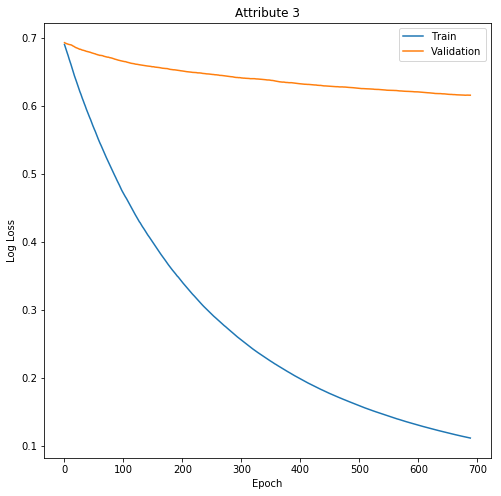

[0]	train-logloss:0.689176	valid-logloss:0.691161
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.375457	valid-logloss:0.523509
[200]	train-logloss:0.243682	valid-logloss:0.463637
[300]	train-logloss:0.166794	valid-logloss:0.42529
[400]	train-logloss:0.121464	valid-logloss:0.402789
[500]	train-logloss:0.093438	valid-logloss:0.391335
[600]	train-logloss:0.073997	valid-logloss:0.379919
[700]	train-logloss:0.060191	valid-logloss:0.371991
[800]	train-logloss:0.050261	valid-logloss:0.366358
Stopping. Best iteration:
[843]	train-logloss:0.04689	valid-logloss:0.363602



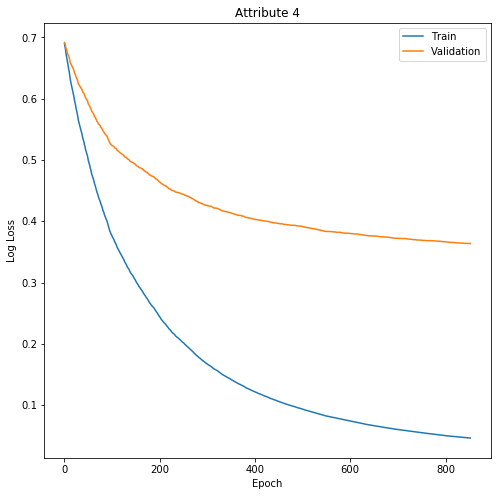

[0]	train-logloss:0.689815	valid-logloss:0.692426
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.403954	valid-logloss:0.585578
[200]	train-logloss:0.27103	valid-logloss:0.539566
[300]	train-logloss:0.189733	valid-logloss:0.498869
[400]	train-logloss:0.140389	valid-logloss:0.471988
[500]	train-logloss:0.109211	valid-logloss:0.454756
[600]	train-logloss:0.087184	valid-logloss:0.4395
[700]	train-logloss:0.071598	valid-logloss:0.428654
[800]	train-logloss:0.060212	valid-logloss:0.420431
[900]	train-logloss:0.051785	valid-logloss:0.414448
[1000]	train-logloss:0.045339	valid-logloss:0.410115
[1100]	train-logloss:0.040125	valid-logloss:0.4065
Stopping. Best iteration:
[1164]	train-logloss:0.037316	valid-logloss:0.404719



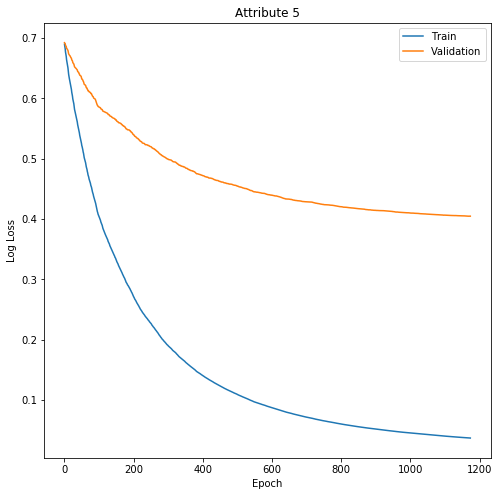

[0]	train-logloss:0.689315	valid-logloss:0.692003
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.380734	valid-logloss:0.554427
[200]	train-logloss:0.246931	valid-logloss:0.493486
[300]	train-logloss:0.167657	valid-logloss:0.444872
[400]	train-logloss:0.122014	valid-logloss:0.411929
[500]	train-logloss:0.093495	valid-logloss:0.389122
[600]	train-logloss:0.0738	valid-logloss:0.370222
[700]	train-logloss:0.05988	valid-logloss:0.354398
[800]	train-logloss:0.049828	valid-logloss:0.342396
[900]	train-logloss:0.042543	valid-logloss:0.334021
[1000]	train-logloss:0.037015	valid-logloss:0.327751
[1100]	train-logloss:0.032456	valid-logloss:0.321309
[1200]	train-logloss:0.028929	valid-logloss:0.316496
[1300]	train-logloss:0.025979	valid-logloss:0.312344
[1400]	train-logloss:0.023572	valid-logloss:0.308994
[1500]	train-logloss:0.021479	valid-logloss:0.305049
[1600]	train-log

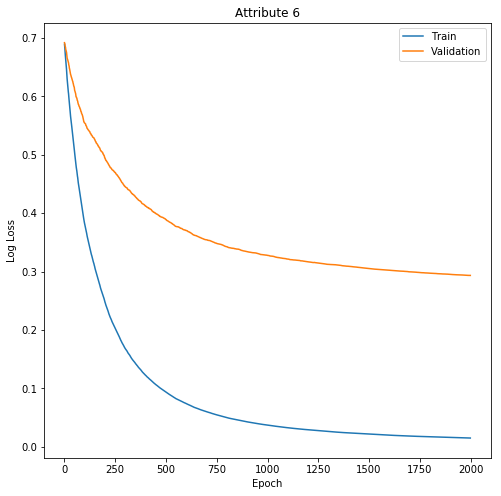

[0]	train-logloss:0.689791	valid-logloss:0.691558
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.385769	valid-logloss:0.537964
[200]	train-logloss:0.253988	valid-logloss:0.48254
[300]	train-logloss:0.175761	valid-logloss:0.450675
[400]	train-logloss:0.129002	valid-logloss:0.434384
[500]	train-logloss:0.099947	valid-logloss:0.42567
Stopping. Best iteration:
[548]	train-logloss:0.088641	valid-logloss:0.421049



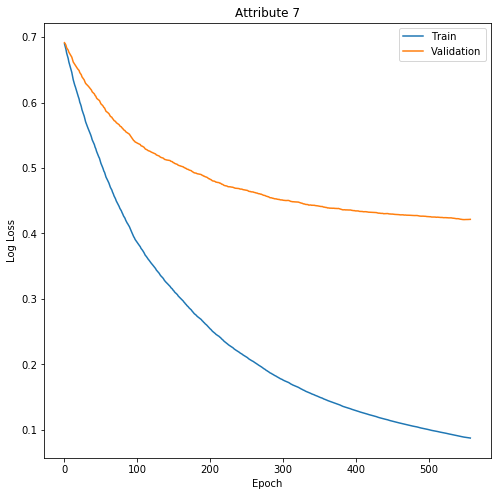

[0]	train-logloss:0.689792	valid-logloss:0.692196
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 10 rounds.
[100]	train-logloss:0.402769	valid-logloss:0.577166
[200]	train-logloss:0.268851	valid-logloss:0.530986
[300]	train-logloss:0.187553	valid-logloss:0.49382
[400]	train-logloss:0.13896	valid-logloss:0.470211
[500]	train-logloss:0.108289	valid-logloss:0.45571
[600]	train-logloss:0.086498	valid-logloss:0.444064
[700]	train-logloss:0.071089	valid-logloss:0.434265
[800]	train-logloss:0.059824	valid-logloss:0.427752
[900]	train-logloss:0.051409	valid-logloss:0.422659
[1000]	train-logloss:0.044882	valid-logloss:0.418118
[1100]	train-logloss:0.039664	valid-logloss:0.41464
Stopping. Best iteration:
[1173]	train-logloss:0.036491	valid-logloss:0.412988



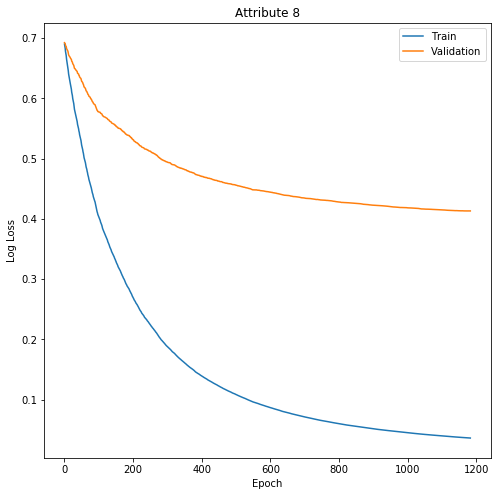

In [7]:
import xgboost as xgb

param = {}
param['objective'] = 'binary:logistic'
param['eta'] = 0.01
param['max_depth'] = 10
param['subsample'] = 0.5
param['eval_metric'] = 'logloss'
param['colsample_bytree'] = 0.3
param['nthread'] = 4

num_round = 2000

y_test_ovr = np.zeros(y_test_averaged.shape, dtype=np.float32)

for i in range(9):
    xg_train = xgb.DMatrix(X_train_reduced, label=y_train_averaged[:,i])
    xg_valid = xgb.DMatrix(X_valid_reduced, label=y_valid_averaged[:,i])
    xg_test = xgb.DMatrix(X_test_reduced, label=y_test_averaged[:,i])

    eval_list = [(xg_train, 'train'),(xg_valid, 'valid')]
    results = {}
    model = xgb.train(param, xg_train, num_round, eval_list, verbose_eval=100, 
                      early_stopping_rounds=10, evals_result=results)

    y_test_ovr[:,i] = model.predict(xg_test)
    
    epochs = len(results['train']['logloss'])
    x_axis = range(0, epochs)
    
    plt.figure(figsize=(8,8))
    plt.ylabel('Log Loss')
    plt.xlabel('Epoch')
    plt.title('Attribute %d' %i)
    plt.plot(x_axis, results['train']['logloss'], label='Train')
    plt.plot(x_axis, results['valid']['logloss'], label='Validation')
    plt.legend()
    plt.show()
        
del xg_train, xg_valid, xg_test

#### $\beta$- $F_1$ score
We calculate the $F_1$ score using a unique threshold of 0.5 for all 9 labels.

In [8]:
yhat_unique = (y_test_ovr >= 0.5).astype(int)
f1_score_ovr = f1_score(y_test_averaged, yhat_unique)

print('F1 score: %.5f' % f1_score_ovr)

F1 score: 0.76503


### B. Classifier Chain

The correlation among classes can be exploited usin [classifier chains](https://en.wikipedia.org/wiki/Classifier_chains).

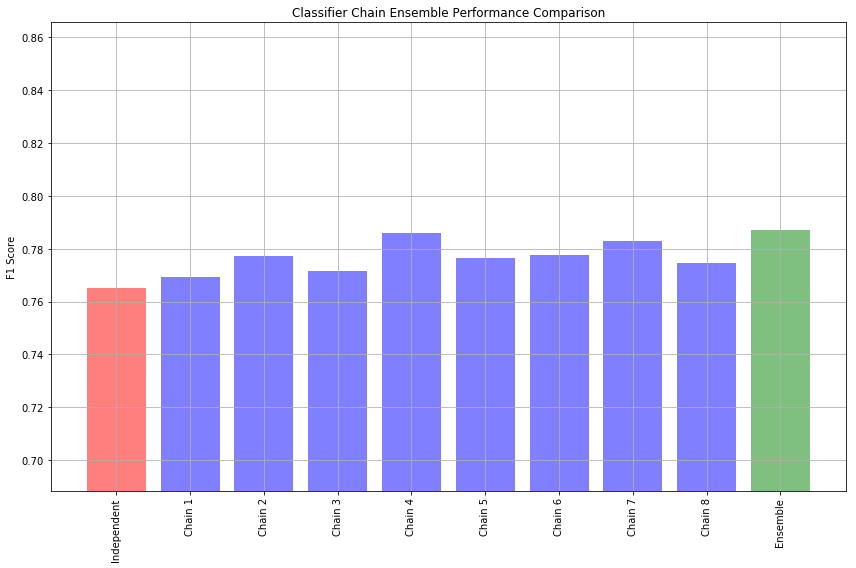

In [9]:
from xgboost import XGBClassifier
from sklearn.multioutput import ClassifierChain

n_chains = 8
chains = [ClassifierChain(XGBClassifier(n_estimators=1000, objective='binary:logistic', eta=0.01, 
                                        max_depth=10, subsample=0.5, eval_metric='logloss', 
                                        colsample_bytree=0.3, nthread=4), 
                          order='random', random_state=i) for i in range(n_chains)]

f1_score_chains = []
y_test_chains = np.array([[0]*9]*len(y_test_averaged), dtype=np.float32)
for chain in chains: 
    chain.fit(X_train_reduced, y_train_averaged)
    y_test_chain = chain.predict_proba(X_test_reduced)
    f1_score_chains.append(f1_score(y_test_averaged,(y_test_chain >= 0.5).astype(int)))
    y_test_chains = y_test_chains + y_test_chain

y_test_ensemble = y_test_chains/n_chains
f1_score_ensemble = f1_score(y_test_averaged, y_test_ensemble >= 0.5)

f1_score_models = [f1_score_ovr] + f1_score_chains
f1_score_models.append(f1_score_ensemble)

name_models = ['Chain ' + str(i) for i in range(1,n_chains+1)]
name_models.insert(0,'Independent')
name_models.append('Ensemble')

x_pos = np.arange(len(name_models))

fig, ax = plt.subplots(figsize=(12, 8))
ax.grid(True)
ax.set_title('Classifier Chain Ensemble Performance Comparison')
ax.set_xticks(x_pos)
ax.set_xticklabels(name_models, rotation='vertical')
ax.set_ylabel('F1 Score')
ax.set_ylim([min(f1_score_models) * .9, max(f1_score_models) * 1.1])
colors = ['r'] + ['b'] * len(f1_score_chains) + ['g']
ax.bar(x_pos, f1_score_models, alpha=0.5, color=colors)
plt.tight_layout()
plt.show()

In [10]:
print("F1 score = %.5f" % f1_score_ensemble)

F1 score = 0.78695
